In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
from matplotlib.pyplot import legend, title
from scipy.special import y0_zeros

sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [2]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
emeApi = lumapi.MODE()

Units

In [3]:
um = 1e-6
nm = 1e-9

Device parameters

In [4]:
#inverse tapers
taper_length      = 5*um
taper_larger_tip  = 12*um
taper_smaller_tip = 0.5*um
taper_tip_sweep = np.linspace(0.01*um, 0.55*um,20)

#wire waveguide
wg_length = 2*um
wg_width  = 0.5*um

wg_length2 = 3*um
wg_width2  = 12*um
#general
height = 220*nm

Materials

In [5]:
materialClad = "SiO2 (Glass) - Palik"
materialSi = "Si (Silicon) - Palik"

In [6]:
emeApi.switchtolayout()
emeApi.deleteall()
emeApi.cleardcard()

In [7]:
emeApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
emeApi.set('name', dev_layer)

Taper

 $z′ = \frac{(z−z0)}{(z1−z0)}$
 
$f(z') = z'$

Where z0 is the starting point and z1 is the ending point


In [8]:
x0 = 0
x1 = taper_length
y0 = taper_larger_tip/2
y1 = taper_smaller_tip/2
a, b, c = 0.4,0.5,7
x = np.linspace(taper_length,0, 100)
#x = np.linspace(0, 1, 100)
alpha = (x-x0)/(x1-x0)
#alpha = (np.exp((x-x0)/(x1-x0))-1)/(np.exp(1)-1)
#alpha =  a*(b*x**2 + (1-b)*x) + (1-a)*np.sin((x*c*np.pi/2))**2
equation = y0 + alpha * (y1-y0)

#equation =  np.sqrt(taper_smaller_tip**2 + (2 * alpha * lambda0 / neff) * x) 
#x = x * taper_length
upper = np.column_stack((x,equation))
lower = np.column_stack((x[::-1], -equation[::-1]))
taper = np.vstack((upper, lower))

In [9]:
emeApi.addpoly()
emeApi.addtogroup(dev_layer)

In [10]:
emeApi.set('name', 'taper')
emeApi.set('vertices', taper)   
emeApi.set('x', 0)
emeApi.set('y', 0)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

    Wire waveguide

In [11]:
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set('name', 'wire waveguide')
emeApi.set('x', taper_length + wg_length/2)
emeApi.set('x span', wg_length)
emeApi.set('y', 0)
emeApi.set('y span', wg_width)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

left wave guide

In [12]:
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set('name', 'wire waveguide 2')
emeApi.set('x', -wg_length2/2)
emeApi.set('x span', wg_length2)
emeApi.set('y', 0)
emeApi.set('y span', wg_width2)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

Analysis    

In [13]:
mesh_cells = 200
emeApi.addeme()

In [14]:
emeApi.switchtolayout()
emeApi.set('x', 0)
emeApi.set('x min', emeApi.getnamed(f'{dev_layer}::wire waveguide 2', 'x min'))
emeApi.set('y', 0)
emeApi.set('y span', taper_larger_tip*1.5)
emeApi.set('z', height/2)
emeApi.set('z span', height*1.5) 
emeApi.set('background material', materialClad)
emeApi.set('mesh cells y', mesh_cells)
emeApi.set('mesh cells z', mesh_cells)

In [15]:
cell_wgd = 1
cell_taper = 10
cell_wgd2 = 1

method_wgd   = 0
method_taper = 1

modes_wgd   = 20
modes_taper = 20

emeApi.set('number of cell groups', 3) #waveguide -> taper -> waveguide
emeApi.set('group spans', np.block([[wg_length2], [taper_length], [wg_length]]))
emeApi.set('cells', np.block([[cell_wgd], [cell_taper], [cell_wgd2]]))
emeApi.set('subcell method', np.block([[method_wgd], [method_taper], [method_wgd]]))
emeApi.set('allow custom eigensolver settings', True)
emeApi.set('modes', np.block([[modes_wgd], [modes_taper], [modes_wgd]]))
emeApi.set('display cells', 1)
'''emeApi.set('number of cell groups', 1) #waveguide -> taper -> waveguide
emeApi.set('group spans', np.block([[taper_length]]))
emeApi.set('cells', np.block([ [cell_taper],]))
emeApi.set('subcell method', np.block([[method_taper]]))
emeApi.set('allow custom eigensolver settings', True)
emeApi.set('modes', np.block([[modes_taper]]))
emeApi.set('display cells', 1)'''

#emeApi.set('min mesh step', 0.5*nm)

#boundary conditions
emeApi.set('y min bc', 'PML')
emeApi.set('y max bc', 'PML')
emeApi.set('z min bc', 'Symmetric')
emeApi.set('z max bc', 'PML')

In [16]:
emeApi.addmesh()
emeApi.set('x', taper_length/2)
emeApi.set('x span', taper_length)
emeApi.set('y', 0)
emeApi.set('y span', taper_larger_tip)  
emeApi.set('z', height/2)
emeApi.set('z span', height)

In [17]:
emeApi.addemeprofile()
emeApi.set('name', 'profile')
emeApi.set('monitor type', 3)
emeApi.set('x', 2*um)
emeApi.set('x span', emeApi.getnamed('EME', 'x span'))
emeApi.set('y',0)
emeApi.set('y span', taper_larger_tip*1.5)
emeApi.set('z', height/2)

simulation

In [18]:
emeApi.save('taperEME')
emeApi.run()

In [22]:
emeApi.emepropagate()

In [23]:
interval = 0.1
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 2')
emeApi.setemeanalysis('start',1*um)
emeApi.setemeanalysis('stop', 6*um)
emeApi.setemeanalysis('interval', interval)
emeApi.emesweep('propagation sweep')
S = emeApi.getemesweep('S')
group_span = S['group_span_2']


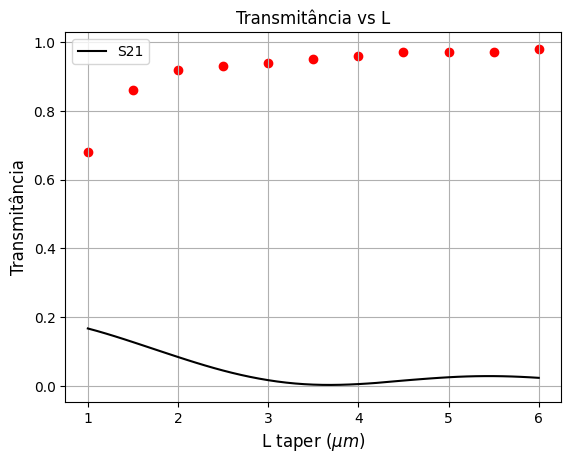

In [25]:
x_article = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
y_article = [0.68, 0.86, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.97, 0.97, 0.98]
T = np.abs(S['s21'])**2
T_dB = 10*np.log10(T)
plt.scatter(x_article, y_article, color='red')
plt.plot(group_span/um, T, 'black', lw=1.5, label='S21')
plt.xlabel(r'L taper $(\mu m)$', fontsize = 12)
plt.ylabel('Transmitância', fontsize = 12)
#plt.xlim([span_box*0.9/um,span_box*1.1/um])
#plt.ylim([0,0.55])
plt.legend()
plt.title(r'Transmitância vs L')
plt.grid(True)
plt.savefig('T')